# Imports


In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from ucimlrepo import fetch_ucirepo

# Decision Trees

This notebook will explore the effectiveness of decision trees and random forests.


### Fetch the datasets

The below code will be used to check that the data is being correctly imported.


In [2]:
folder_path = os.path.join("..", "dataset")
data_path = os.path.join(folder_path, "data.csv")
labels_path = os.path.join(folder_path, "labels.csv")

In [3]:
def check_if_dataset_exists():
    data_exists = os.path.exists(data_path)
    labels_exists = os.path.exists(labels_path)
    return data_exists and labels_exists

In [4]:
def read_in_from_csv():
    x = pd.read_csv(data_path, sep=";")
    y = pd.read_csv(labels_path, sep=";")
    return x, y

In [5]:
def save_to_csv(x, y):
    os.makedirs(os.path.dirname(data_path), exist_ok=True)
    os.makedirs(os.path.dirname(labels_path), exist_ok=True)
    x.to_csv(data_path, index=False, sep=";")
    y.to_csv(labels_path, index=False, sep=";")

In [6]:
def fetch_dataset():
    print("Fetching dataset...")
    bank_marketing = fetch_ucirepo(id=222)
    x = bank_marketing.data.features
    y = bank_marketing.data.targets
    save_to_csv(x, y)

    os.makedirs(os.path.dirname(folder_path), exist_ok=True)
    bank_marketing.variables.to_csv(
        os.path.join(folder_path, "variables.csv"), index=False
    )
    return x, y, bank_marketing.variables

In [7]:
dataset_exists = check_if_dataset_exists()

if dataset_exists:
    print("Dataset already exists.")
    x, y = read_in_from_csv()
    variables = pd.read_csv(os.path.join(folder_path, "variables.csv"))
else:
    x, y, variables = fetch_dataset()

Dataset already exists.


In [8]:
variables

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,NaN,NaN,no
1,job,Feature,Categorical,Occupation,"type of job (categorical: 'admin.','blue-colla...",NaN,no
2,marital,Feature,Categorical,Marital Status,"marital status (categorical: 'divorced','marri...",NaN,no
3,education,Feature,Categorical,Education Level,"(categorical: 'basic.4y','basic.6y','basic.9y'...",NaN,no
4,default,Feature,Binary,NaN,has credit in default?,NaN,no
5,balance,Feature,Integer,NaN,average yearly balance,euros,no
6,housing,Feature,Binary,NaN,has housing loan?,NaN,no
7,loan,Feature,Binary,NaN,has personal loan?,NaN,no
8,contact,Feature,Categorical,NaN,contact communication type (categorical: 'cell...,NaN,yes
9,day_of_week,Feature,Date,NaN,last contact day of the week,NaN,no


In [9]:
x

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,NaN
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,NaN
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,NaN


In [10]:
y

,y
0,no
1,no
2,no
3,no
4,no
...,...
45206,yes
45207,yes
45208,yes
45209,no


### Explore the data

The below code will explore the dataset.


In [11]:
class Columns:
    AGE = "age"
    JOB = "job"
    MARITAL = "marital"
    EDUCATION = "education"
    DEFAULT = "default"
    BALANCE = "balance"
    HOUSING = "housing"
    LOAN = "loan"
    CONTACT = "contact"
    DAY_OF_WEEK = "day_of_week"
    MONTH = "month"
    DURATION = "duration"
    CAMPAIGN = "campaign"
    PASSED_DAYS = "pdays"
    PREVIOUS = "previous"
    PREVIOUS_OUTCOME = "poutcome"
    TARGET = "y"

In [12]:
def explore_numerical_feature(df, column):
    print("Descriptive Stats:")
    print(df[column].describe())
    print("\nNumber NA: ", end="")
    print(x[column].isna().sum())
    sns.kdeplot(x[column], fill=True)
    plt.title(f"KDE of {column.capitalize()}")
    plt.xlabel(column)
    plt.ylabel("Density")
    plt.show()

In [13]:
def explore_categorical_feature(df, column):
    print(f"{column} counts:")
    sorted_column_counts = df[column].value_counts(dropna=False).sort_index()
    print(sorted_column_counts)

    print()
    print("Number NA: ", len(df[df[column].isna()]))

    sorted_column_counts.plot(kind="barh", figsize=(10, 6))
    plt.title(f"{column.capitalize()} Distribution")
    plt.xlabel("Count")
    plt.ylabel(column.capitalize())
    plt.show()

In [14]:
def replace_NaN_with_unknown(df, column):
    number_unknown = len(df[df[column].isna()])
    if number_unknown > 0:
        df[column] = df[column].fillna("unknown")
    assert len(df[df[column].isna()]) == 0
    return df

#### Age


Descriptive Stats:
count    45211.000000
mean        40.936210
std         10.618762
min         18.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

Number NA: 0


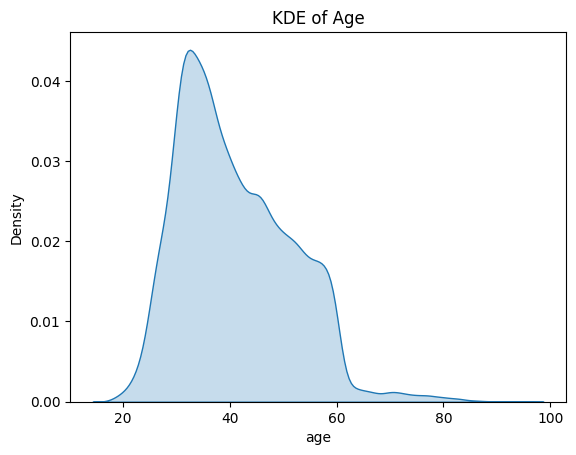

In [15]:
explore_numerical_feature(x, Columns.AGE)

#### Job


job counts:
job
admin.           5171
blue-collar      9732
entrepreneur     1487
housemaid        1240
management       9458
retired          2264
self-employed    1579
services         4154
student           938
technician       7597
unemployed       1303
NaN               288
Name: count, dtype: int64

Number NA:  288


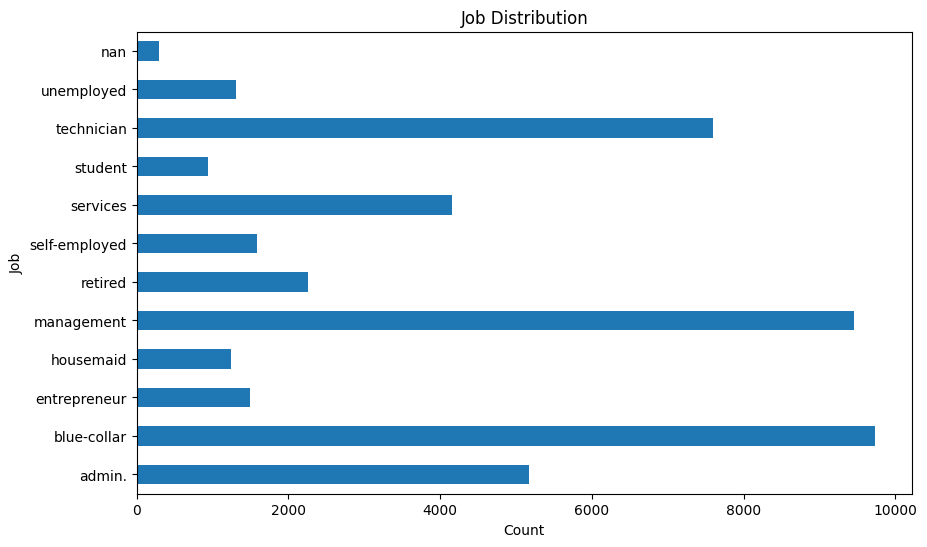

In [16]:
explore_categorical_feature(x, Columns.JOB)

In [17]:
x = replace_NaN_with_unknown(x, Columns.JOB)

job counts:
job
admin.           5171
blue-collar      9732
entrepreneur     1487
housemaid        1240
management       9458
retired          2264
self-employed    1579
services         4154
student           938
technician       7597
unemployed       1303
unknown           288
Name: count, dtype: int64

Number NA:  0


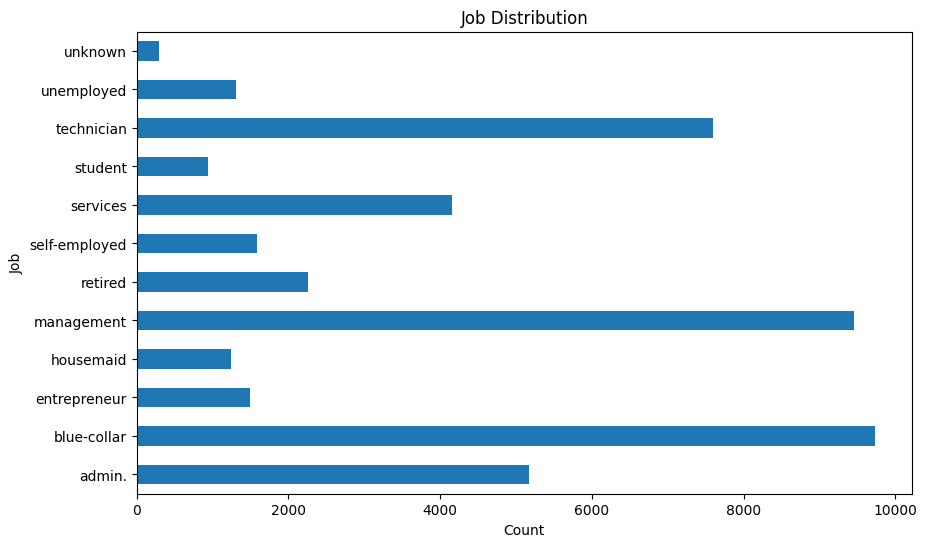

In [18]:
explore_categorical_feature(x, Columns.JOB)

#### Marital


marital counts:
marital
divorced     5207
married     27214
single      12790
Name: count, dtype: int64

Number NA:  0


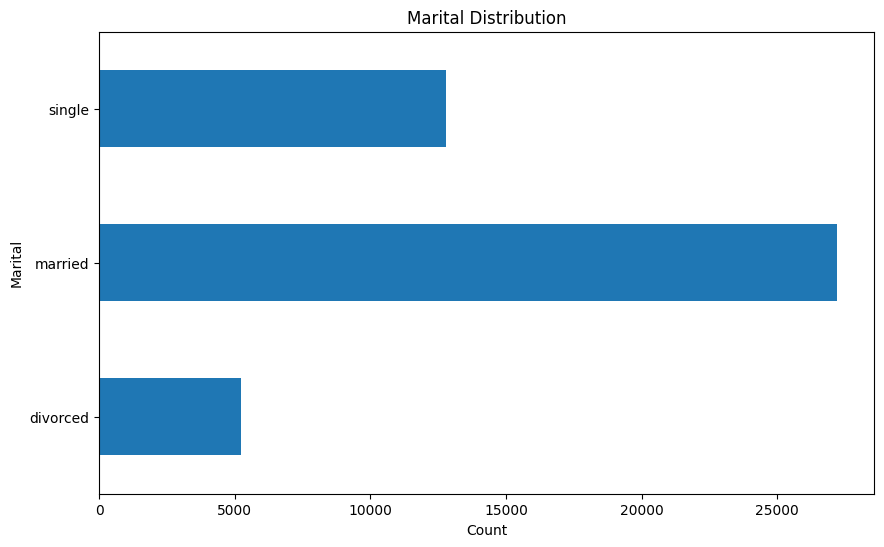

In [19]:
explore_categorical_feature(x, Columns.MARITAL)

#### Education


education counts:
education
primary       6851
secondary    23202
tertiary     13301
NaN           1857
Name: count, dtype: int64

Number NA:  1857


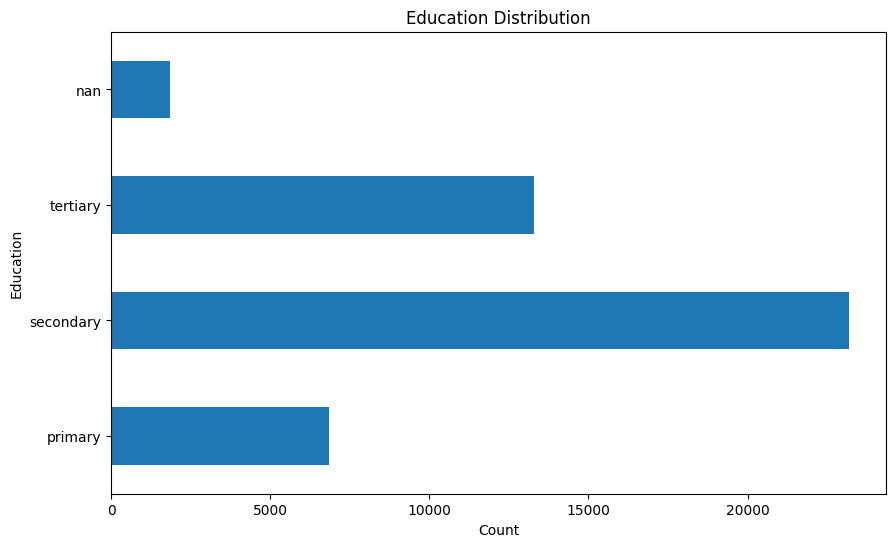

In [20]:
explore_categorical_feature(x, Columns.EDUCATION)

In [21]:
x = replace_NaN_with_unknown(x, Columns.EDUCATION)

education counts:
education
primary       6851
secondary    23202
tertiary     13301
unknown       1857
Name: count, dtype: int64

Number NA:  0


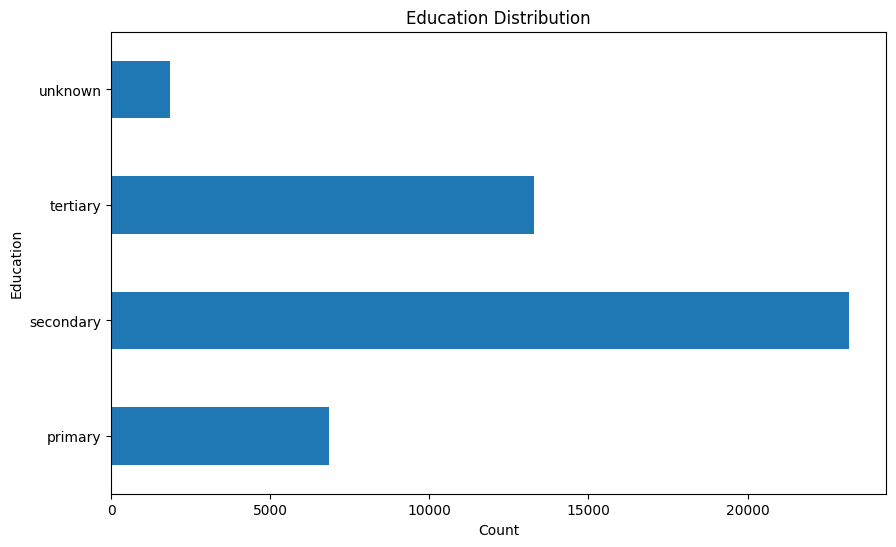

In [22]:
explore_categorical_feature(x, Columns.EDUCATION)

#### Default

Has credit in default?


default counts:
default
no     44396
yes      815
Name: count, dtype: int64

Number NA:  0


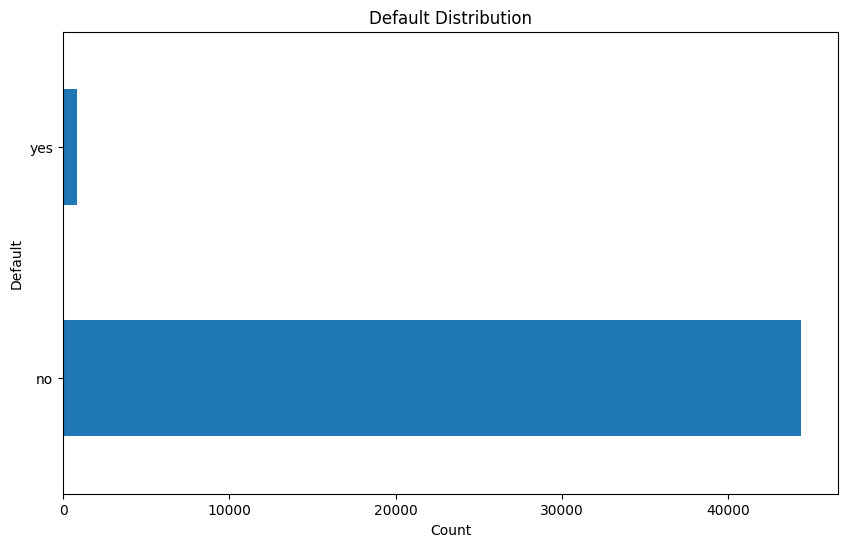

In [23]:
explore_categorical_feature(x, Columns.DEFAULT)

#### Balance

Average yearly balance measured in Euros.


Descriptive Stats:
count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64

Number NA: 0


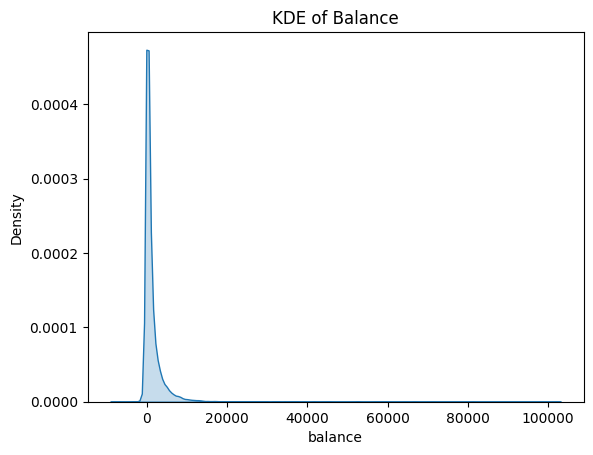

In [24]:
explore_numerical_feature(x, Columns.BALANCE)

#### Housing

Has a housing loan?


housing counts:
housing
no     20081
yes    25130
Name: count, dtype: int64

Number NA:  0


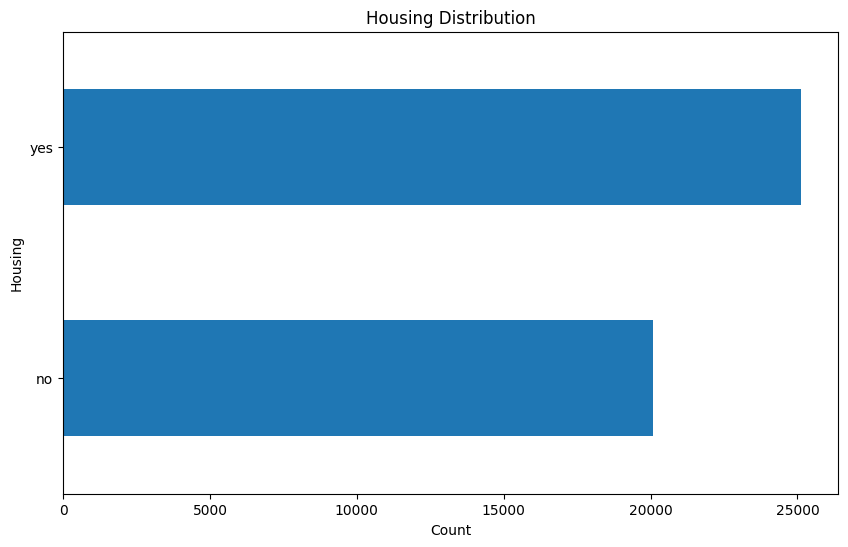

In [25]:
explore_categorical_feature(x, Columns.HOUSING)

#### Loan

Has a personal loan?


loan counts:
loan
no     37967
yes     7244
Name: count, dtype: int64

Number NA:  0


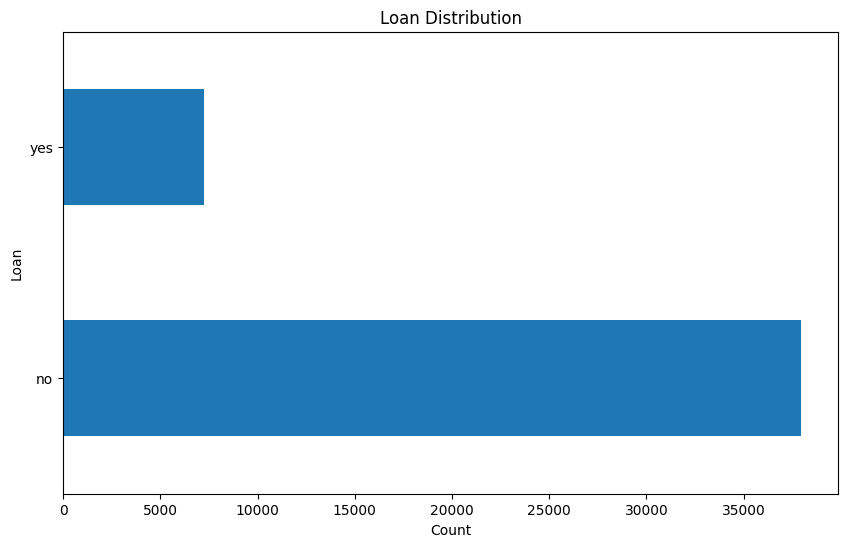

In [26]:
explore_categorical_feature(x, Columns.LOAN)

#### Contact

Contact communication type.


contact counts:
contact
cellular     29285
telephone     2906
NaN          13020
Name: count, dtype: int64

Number NA:  13020


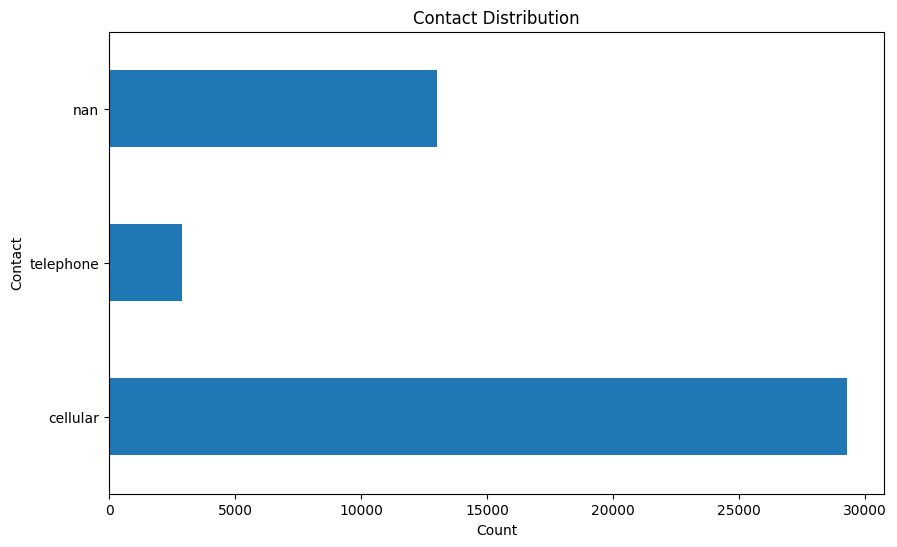

In [27]:
explore_categorical_feature(x, Columns.CONTACT)

In [28]:
x = replace_NaN_with_unknown(x, Columns.CONTACT)

contact counts:
contact
cellular     29285
telephone     2906
unknown      13020
Name: count, dtype: int64

Number NA:  0


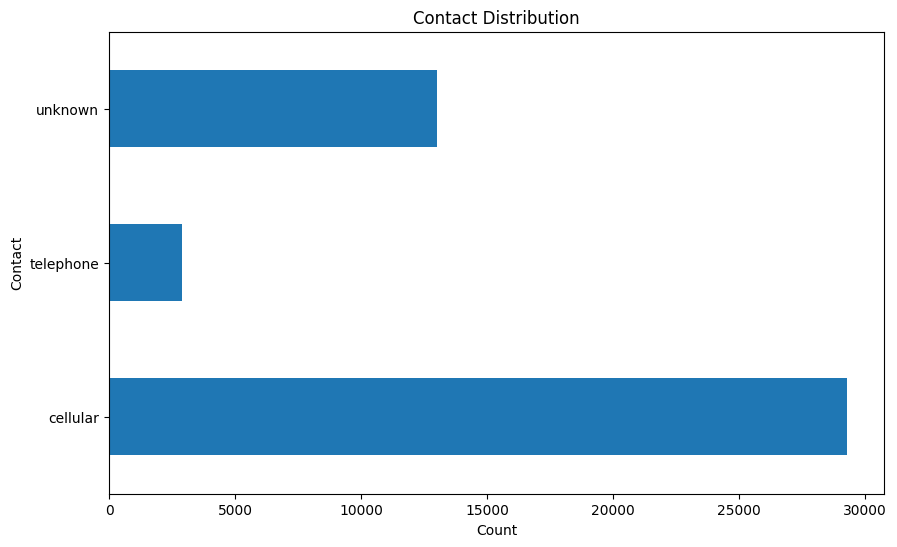

In [29]:
explore_categorical_feature(x, Columns.CONTACT)

#### Day of Week

Last contact day of the week.


day_of_week counts:
day_of_week
1      322
2     1293
3     1079
4     1445
5     1910
6     1932
7     1817
8     1842
9     1561
10     524
11    1479
12    1603
13    1585
14    1848
15    1703
16    1415
17    1939
18    2308
19    1757
20    2752
21    2026
22     905
23     939
24     447
25     840
26    1035
27    1121
28    1830
29    1745
30    1566
31     643
Name: count, dtype: int64

Number NA:  0


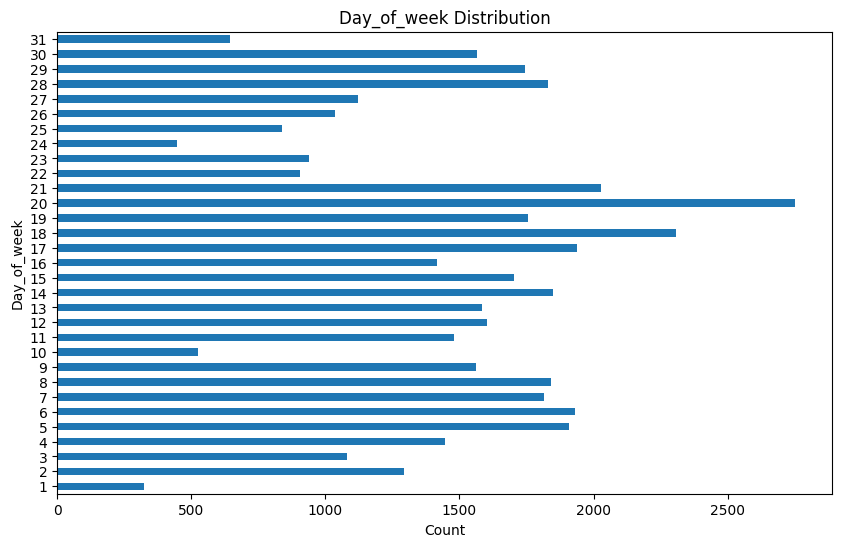

In [30]:
explore_categorical_feature(x, Columns.DAY_OF_WEEK)

#### Month


month counts:
month
apr     2932
aug     6247
dec      214
feb     2649
jan     1403
jul     6895
jun     5341
mar      477
may    13766
nov     3970
oct      738
sep      579
Name: count, dtype: int64

Number NA:  0


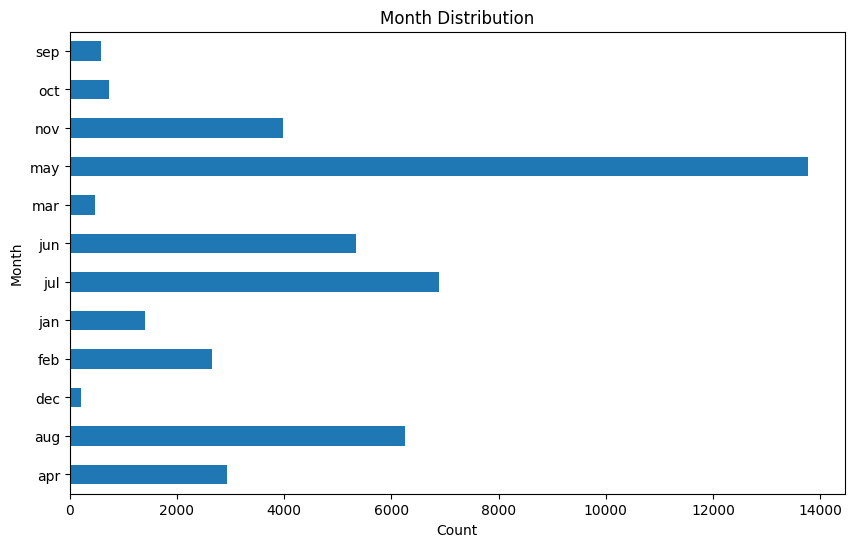

In [31]:
explore_categorical_feature(x, Columns.MONTH)

#### Duration

Last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.


Descriptive Stats:
count    45211.000000
mean       258.163080
std        257.527812
min          0.000000
25%        103.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64

Number NA: 0


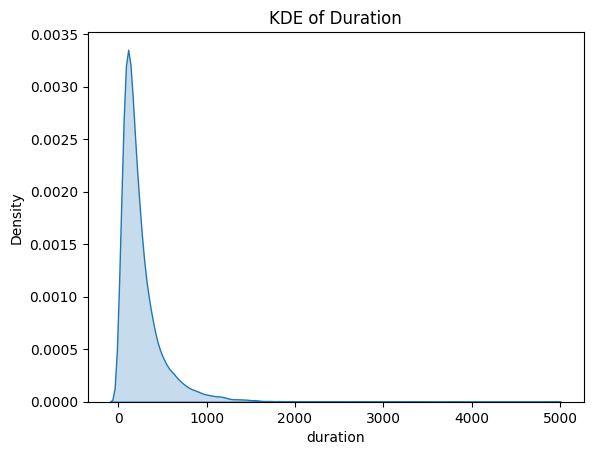

In [32]:
explore_numerical_feature(x, Columns.DURATION)

#### Campaign

Number of contacts performed during this campaign and for this client (numeric, includes last contact.


Descriptive Stats:
count    45211.000000
mean         2.763841
std          3.098021
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: campaign, dtype: float64

Number NA: 0


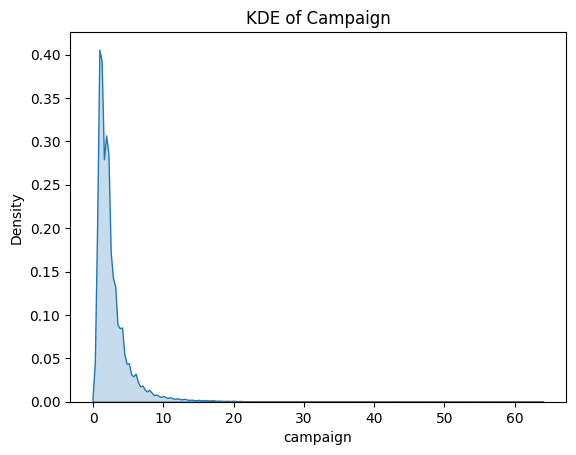

In [33]:
explore_numerical_feature(x, Columns.CAMPAIGN)

#### Passed Days

Number of days that passed by after the client was last contacted from a previous campaign (numeric; -1 means client was not previously contacted)


Descriptive Stats:
count    45211.000000
mean        40.197828
std        100.128746
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max        871.000000
Name: pdays, dtype: float64

Number NA: 0


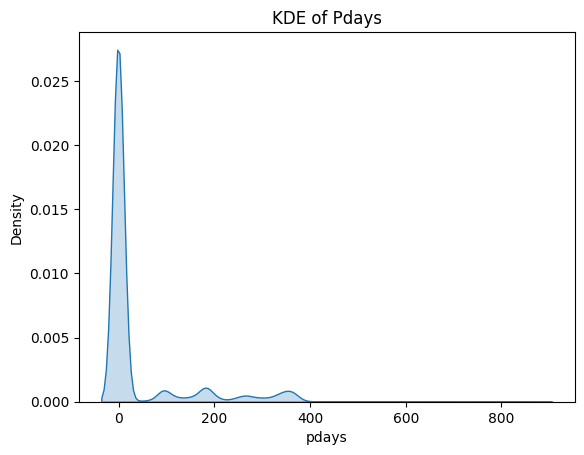

In [34]:
explore_numerical_feature(x, Columns.PASSED_DAYS)

#### Previous

Number of contacts performed before this campaign and for this client.


Descriptive Stats:
count    45211.000000
mean         0.580323
std          2.303441
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        275.000000
Name: previous, dtype: float64

Number NA: 0


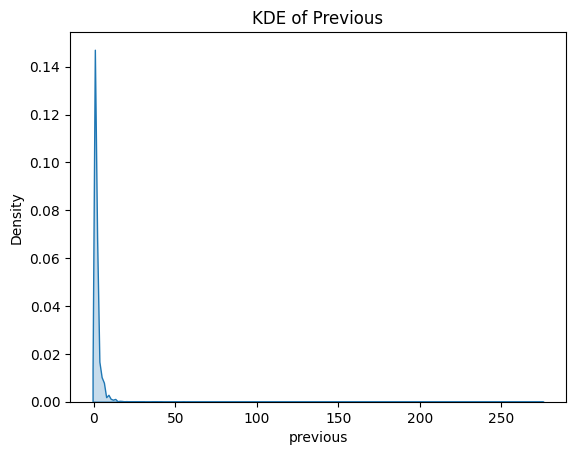

In [35]:
explore_numerical_feature(x, Columns.PREVIOUS)

#### Previous Outcome

Outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success').


poutcome counts:
poutcome
failure     4901
other       1840
success     1511
NaN        36959
Name: count, dtype: int64

Number NA:  36959


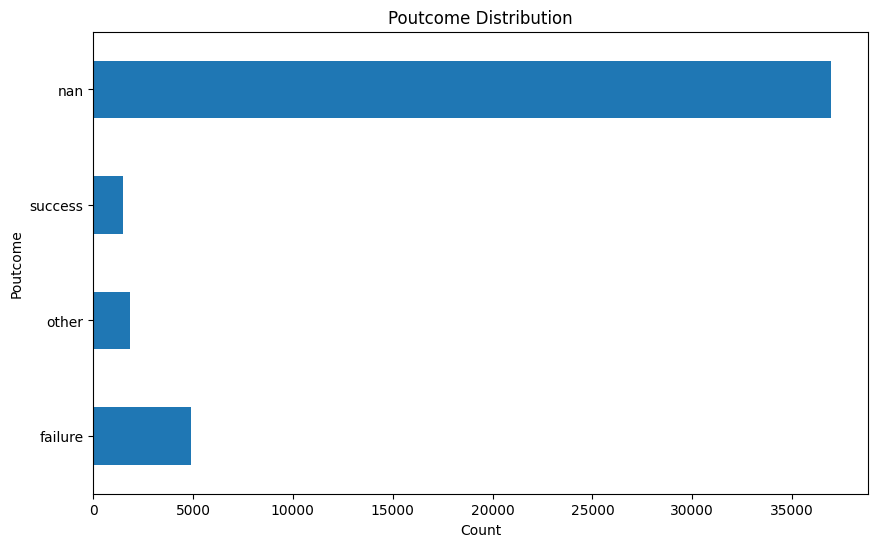

In [36]:
explore_categorical_feature(x, Columns.PREVIOUS_OUTCOME)

In [37]:
x = replace_NaN_with_unknown(x, Columns.PREVIOUS_OUTCOME)

poutcome counts:
poutcome
failure     4901
other       1840
success     1511
unknown    36959
Name: count, dtype: int64

Number NA:  0


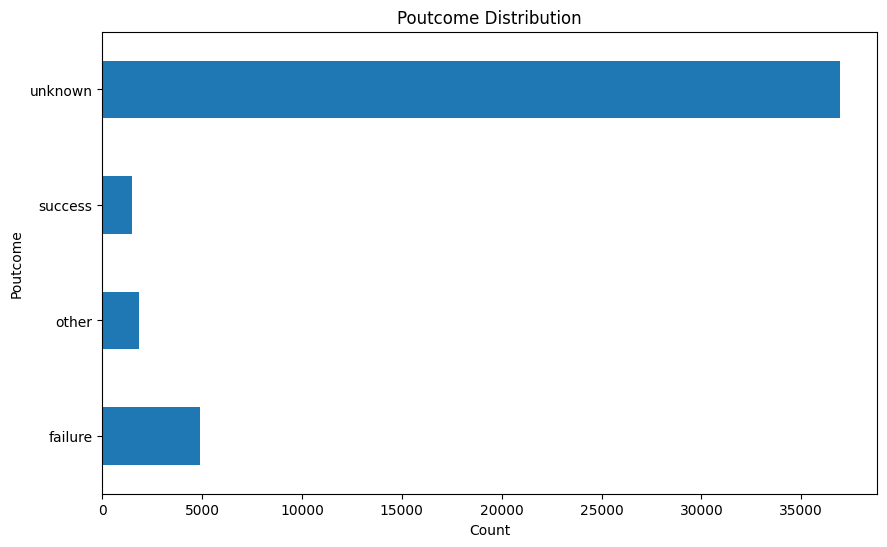

In [38]:
explore_categorical_feature(x, Columns.PREVIOUS_OUTCOME)

#### Target


y counts:
y
no     39922
yes     5289
Name: count, dtype: int64

Number NA:  0


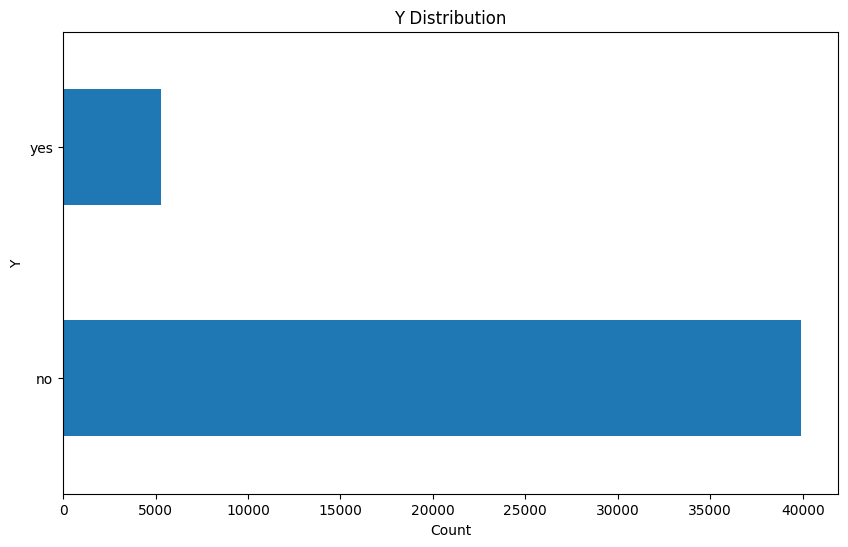

In [39]:
explore_categorical_feature(y, Columns.TARGET)

In [40]:
num_positive = len(y[y[Columns.TARGET] == "yes"])
num_negative = len(y[y[Columns.TARGET] == "no"])
assert num_negative + num_positive == len(x)

positive_percentage = round(num_positive * 100 / len(x), 2)
negative_percentage = round(num_negative * 100 / len(x), 2)

print(f"Positive Percentage: {positive_percentage}%")
print(f"Negative Percentage: {negative_percentage}%")

Positive Percentage: 11.7%
Negative Percentage: 88.3%


## Modelling


In [41]:
variables

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,NaN,NaN,no
1,job,Feature,Categorical,Occupation,"type of job (categorical: 'admin.','blue-colla...",NaN,no
2,marital,Feature,Categorical,Marital Status,"marital status (categorical: 'divorced','marri...",NaN,no
3,education,Feature,Categorical,Education Level,"(categorical: 'basic.4y','basic.6y','basic.9y'...",NaN,no
4,default,Feature,Binary,NaN,has credit in default?,NaN,no
5,balance,Feature,Integer,NaN,average yearly balance,euros,no
6,housing,Feature,Binary,NaN,has housing loan?,NaN,no
7,loan,Feature,Binary,NaN,has personal loan?,NaN,no
8,contact,Feature,Categorical,NaN,contact communication type (categorical: 'cell...,NaN,yes
9,day_of_week,Feature,Date,NaN,last contact day of the week,NaN,no


In [42]:
x.drop(Columns.DURATION, axis=1, inplace=True)
x

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,3,-1,0,unknown
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,2,-1,0,unknown
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,5,184,3,success
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,4,-1,0,unknown


In [43]:
columns_to_encode = [
    Columns.JOB,
    Columns.MARITAL,
    Columns.EDUCATION,
    Columns.CONTACT,
    Columns.PREVIOUS_OUTCOME,
]
categorical_encoded = pd.get_dummies(
    x[columns_to_encode], prefix={col: col for col in columns_to_encode}
)
categorical_encoded

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,False,False,False,False,True,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,True
1,False,False,False,False,False,False,False,False,False,True,...,True,False,False,False,False,True,False,False,False,True
2,False,False,True,False,False,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,True
3,False,True,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,True
4,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,False,False,False,False,False,False,False,False,False,True,...,False,True,False,True,False,False,False,False,False,True
45207,False,False,False,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
45208,False,False,False,False,False,True,False,False,False,False,...,True,False,False,True,False,False,False,False,True,False
45209,False,True,False,False,False,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,True


In [44]:
month_encoded = pd.get_dummies(x[Columns.MONTH], prefix=Columns.MONTH)
month_encoded

,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,False,False,False,False,False,False,False,False,True,False,False,False
1,False,False,False,False,False,False,False,False,True,False,False,False
2,False,False,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,False,False,False,False,True,False,False,False
4,False,False,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
45206,False,False,False,False,False,False,False,False,False,True,False,False
45207,False,False,False,False,False,False,False,False,False,True,False,False
45208,False,False,False,False,False,False,False,False,False,True,False,False
45209,False,False,False,False,False,False,False,False,False,True,False,False


In [45]:
day_of_week_encoded = pd.get_dummies(x[Columns.DAY_OF_WEEK], prefix=Columns.DAY_OF_WEEK)
day_of_week_encoded

,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day_of_week_7,day_of_week_8,day_of_week_9,day_of_week_10,...,day_of_week_22,day_of_week_23,day_of_week_24,day_of_week_25,day_of_week_26,day_of_week_27,day_of_week_28,day_of_week_29,day_of_week_30,day_of_week_31
0,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
45207,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
45208,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
45209,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [46]:
df_combined = pd.concat(
    [x, categorical_encoded, month_encoded, day_of_week_encoded], axis=1
)
df_combined.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day_of_week', 'month', 'campaign', 'pdays',
       'previous', 'poutcome', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'education_unknown', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown', 'month_apr',
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'day_of_week_6

In [47]:
df_combined = df_combined.drop(
    columns_to_encode + [Columns.DAY_OF_WEEK] + [Columns.MONTH], axis=1
)
df_combined.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'campaign', 'pdays',
       'previous', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'contact_cellular', 'contact_telephone',
       'contact_unknown', 'poutcome_failure', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'day_of_week_5', 'day_of_week_6', 'day_of_week_7', 'day_of_week_8',
       'day_of_week_9', 'day_of_week_10', 'day_o

In [48]:
df_combined

,age,default,balance,housing,loan,campaign,pdays,previous,job_admin.,job_blue-collar,...,day_of_week_22,day_of_week_23,day_of_week_24,day_of_week_25,day_of_week_26,day_of_week_27,day_of_week_28,day_of_week_29,day_of_week_30,day_of_week_31
0,58,no,2143,yes,no,1,-1,0,False,False,...,False,False,False,False,False,False,False,False,False,False
1,44,no,29,yes,no,1,-1,0,False,False,...,False,False,False,False,False,False,False,False,False,False
2,33,no,2,yes,yes,1,-1,0,False,False,...,False,False,False,False,False,False,False,False,False,False
3,47,no,1506,yes,no,1,-1,0,False,True,...,False,False,False,False,False,False,False,False,False,False
4,33,no,1,no,no,1,-1,0,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,no,825,no,no,3,-1,0,False,False,...,False,False,False,False,False,False,False,False,False,False
45207,71,no,1729,no,no,2,-1,0,False,False,...,False,False,False,False,False,False,False,False,False,False
45208,72,no,5715,no,no,5,184,3,False,False,...,False,False,False,False,False,False,False,False,False,False
45209,57,no,668,no,no,4,-1,0,False,True,...,False,False,False,False,False,False,False,False,False,False


In [49]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 77 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age                  45211 non-null  int64 
 1   default              45211 non-null  object
 2   balance              45211 non-null  int64 
 3   housing              45211 non-null  object
 4   loan                 45211 non-null  object
 5   campaign             45211 non-null  int64 
 6   pdays                45211 non-null  int64 
 7   previous             45211 non-null  int64 
 8   job_admin.           45211 non-null  bool  
 9   job_blue-collar      45211 non-null  bool  
 10  job_entrepreneur     45211 non-null  bool  
 11  job_housemaid        45211 non-null  bool  
 12  job_management       45211 non-null  bool  
 13  job_retired          45211 non-null  bool  
 14  job_self-employed    45211 non-null  bool  
 15  job_services         45211 non-null  bool  
 16  job_

In [50]:
for column in [Columns.DEFAULT, Columns.HOUSING, Columns.LOAN]:
    df_combined[column] = df_combined[column].map({"yes": True, "no": False})

df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 77 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  45211 non-null  int64
 1   default              45211 non-null  bool 
 2   balance              45211 non-null  int64
 3   housing              45211 non-null  bool 
 4   loan                 45211 non-null  bool 
 5   campaign             45211 non-null  int64
 6   pdays                45211 non-null  int64
 7   previous             45211 non-null  int64
 8   job_admin.           45211 non-null  bool 
 9   job_blue-collar      45211 non-null  bool 
 10  job_entrepreneur     45211 non-null  bool 
 11  job_housemaid        45211 non-null  bool 
 12  job_management       45211 non-null  bool 
 13  job_retired          45211 non-null  bool 
 14  job_self-employed    45211 non-null  bool 
 15  job_services         45211 non-null  bool 
 16  job_student          4

In [51]:
df_combined

,age,default,balance,housing,loan,campaign,pdays,previous,job_admin.,job_blue-collar,...,day_of_week_22,day_of_week_23,day_of_week_24,day_of_week_25,day_of_week_26,day_of_week_27,day_of_week_28,day_of_week_29,day_of_week_30,day_of_week_31
0,58,False,2143,True,False,1,-1,0,False,False,...,False,False,False,False,False,False,False,False,False,False
1,44,False,29,True,False,1,-1,0,False,False,...,False,False,False,False,False,False,False,False,False,False
2,33,False,2,True,True,1,-1,0,False,False,...,False,False,False,False,False,False,False,False,False,False
3,47,False,1506,True,False,1,-1,0,False,True,...,False,False,False,False,False,False,False,False,False,False
4,33,False,1,False,False,1,-1,0,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,False,825,False,False,3,-1,0,False,False,...,False,False,False,False,False,False,False,False,False,False
45207,71,False,1729,False,False,2,-1,0,False,False,...,False,False,False,False,False,False,False,False,False,False
45208,72,False,5715,False,False,5,184,3,False,False,...,False,False,False,False,False,False,False,False,False,False
45209,57,False,668,False,False,4,-1,0,False,True,...,False,False,False,False,False,False,False,False,False,False


In [52]:
y["y"] = y["y"].map({"yes": True, "no": False})
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   y       45211 non-null  bool 
dtypes: bool(1)
memory usage: 44.3 KB


### Model 1

This model is just a basic decision tree.


In [53]:
random_sate = 42

In [54]:
x_train, x_test, y_train, y_test = train_test_split(
    df_combined, y, test_size=0.2, random_state=random_sate
)

In [55]:
def plot_roc_curve(y_prob, y_test):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [56]:
def plot_confusion_matrix(y_pred, y_test):
    cm = confusion_matrix(y_test, y_pred)
    classification_report_output = classification_report(y_test, y_pred)
    accuracy_score_lib = accuracy_score(y_test, y_pred)

    tn = cm[0][0]
    tp = cm[1][1]
    fn = cm[1][0]
    fp = cm[0][1]

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=["Predicted: 0", "Predicted: 1"],
        yticklabels=["Actual: 0", "Actual: 1"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    print(classification_report_output)
    print(f"Accuracy (Calculated): {accuracy}")
    print(f"Accuracy (Library): {accuracy_score_lib}")
    print(f"Recall: {recall}")
    print(f"precision: {precision}")

In [57]:
model = DecisionTreeClassifier(random_state=random_sate)
model.fit(x_train, y_train)

DecisionTreeClassifier(random_state=42)

In [58]:
y_pred = model.predict(x_test)
y_prob = model.predict_proba(x_test)[:, 1]

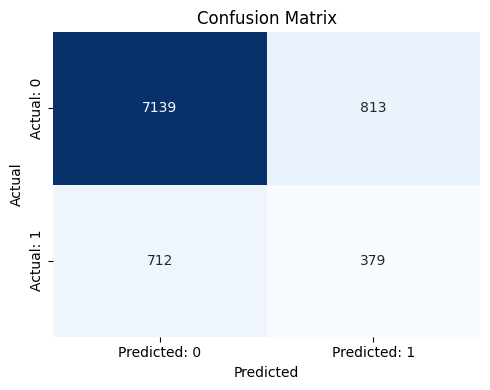

              precision    recall  f1-score   support

       False       0.91      0.90      0.90      7952
        True       0.32      0.35      0.33      1091

    accuracy                           0.83      9043
   macro avg       0.61      0.62      0.62      9043
weighted avg       0.84      0.83      0.83      9043

Accuracy (Calculated): 0.8313612739135243
Accuracy (Library): 0.8313612739135243
Recall: 0.3473877176901925
precision: 0.3179530201342282


In [59]:
plot_confusion_matrix(y_pred, y_test)

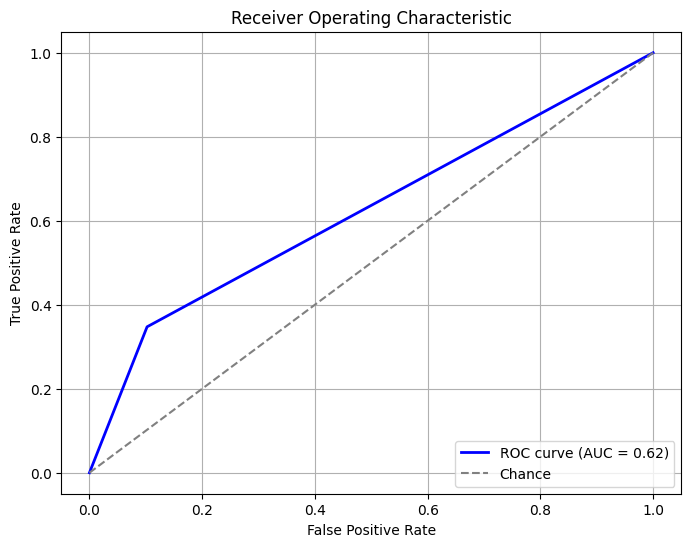

In [60]:
plot_roc_curve(y_prob, y_test)

[Text(0.9110540396955051, 0.9901960784313726, 'x[32] <= 0.5\ngini = 0.205\nsamples = 36168\nvalue = [31970, 4198]'),
 Text(0.8476863327048577, 0.9705882352941176, 'x[0] <= 60.5\ngini = 0.177\nsamples = 34958\nvalue = [31536, 3422]'),
 Text(0.8793701862001815, 0.9803921568627452, 'True  '),
 Text(0.7647606804126901, 0.9509803921568627, 'x[29] <= 0.5\ngini = 0.166\nsamples = 34173\nvalue = [31044, 3129]'),
 Text(0.6724900315925194, 0.9313725490196079, 'x[40] <= 0.5\ngini = 0.203\nsamples = 23811\nvalue = [21081, 2730]'),
 Text(0.6536325803538412, 0.9117647058823529, 'x[41] <= 0.5\ngini = 0.194\nsamples = 23280\nvalue = [20746, 2534]'),
 Text(0.6308603577927216, 0.8921568627450981, 'x[44] <= 0.5\ngini = 0.187\nsamples = 23012\nvalue = [20605, 2407]'),
 Text(0.5980878956764086, 0.8725490196078431, 'x[45] <= 0.5\ngini = 0.18\nsamples = 22661\nvalue = [20388, 2273]'),
 Text(0.55472258379236, 0.8529411764705882, 'x[6] <= 384.0\ngini = 0.175\nsamples = 22417\nvalue = [20248, 2169]'),
 Text(0.4

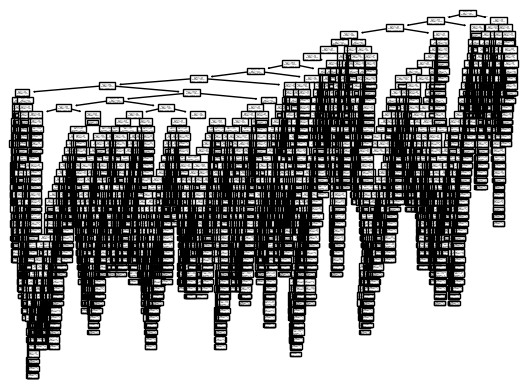

In [61]:
tree.plot_tree(model)

### Model 2


In [62]:
model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

In [63]:
param_grid = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "criterion": ["gini", "entropy"],
}

grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10, None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10]})

In [64]:
print("Best Parameters:", grid.best_params_)
model = grid.best_estimator_

Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [65]:
y_pred = model.predict(x_test)
y_prob = model.predict_proba(x_test)[:, 1]

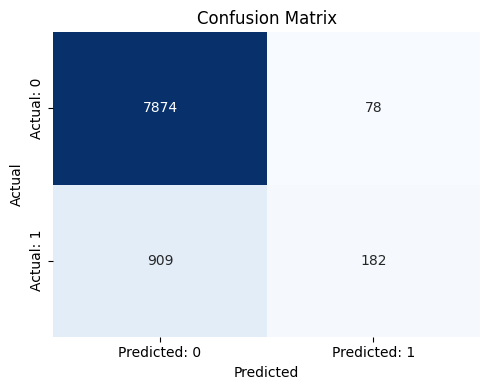

              precision    recall  f1-score   support

       False       0.90      0.99      0.94      7952
        True       0.70      0.17      0.27      1091

    accuracy                           0.89      9043
   macro avg       0.80      0.58      0.61      9043
weighted avg       0.87      0.89      0.86      9043

Accuracy (Calculated): 0.8908548048214088
Accuracy (Library): 0.8908548048214088
Recall: 0.16681943171402383
precision: 0.7


In [66]:
plot_confusion_matrix(y_pred, y_test)

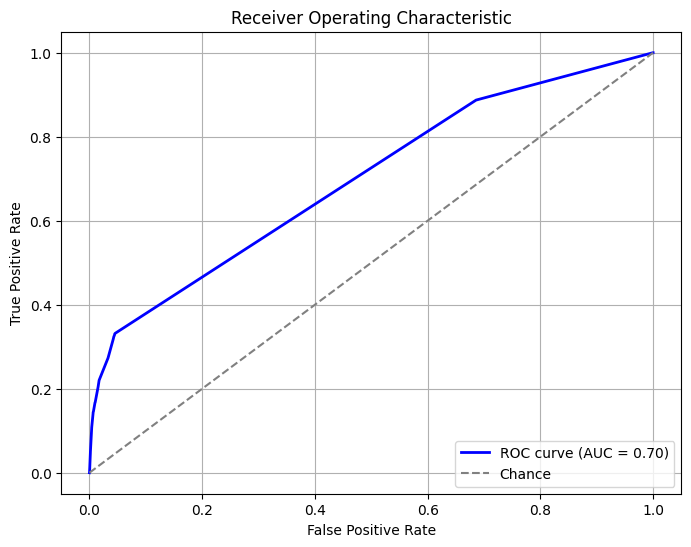

In [67]:
plot_roc_curve(y_prob, y_test)

### Model 3


In [68]:
model = RandomForestClassifier(n_estimators=100, random_state=random_sate)
model.fit(x_train, y_train)

/Users/jmanwillz/Desktop/ACML-Project/ACML-Project/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=42)

In [69]:
y_pred = model.predict(x_test)
y_prob = model.predict_proba(x_test)[:, 1]

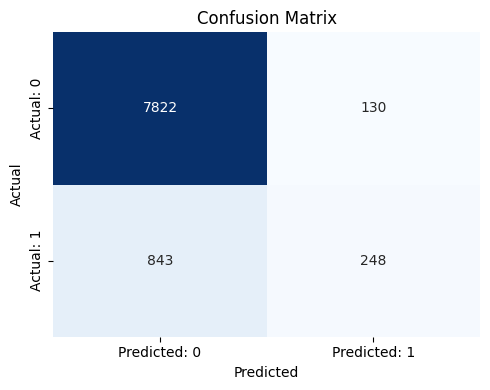

              precision    recall  f1-score   support

       False       0.90      0.98      0.94      7952
        True       0.66      0.23      0.34      1091

    accuracy                           0.89      9043
   macro avg       0.78      0.61      0.64      9043
weighted avg       0.87      0.89      0.87      9043

Accuracy (Calculated): 0.8924029636182683
Accuracy (Library): 0.8924029636182683
Recall: 0.22731439046746105
precision: 0.656084656084656


In [70]:
plot_confusion_matrix(y_pred, y_test)

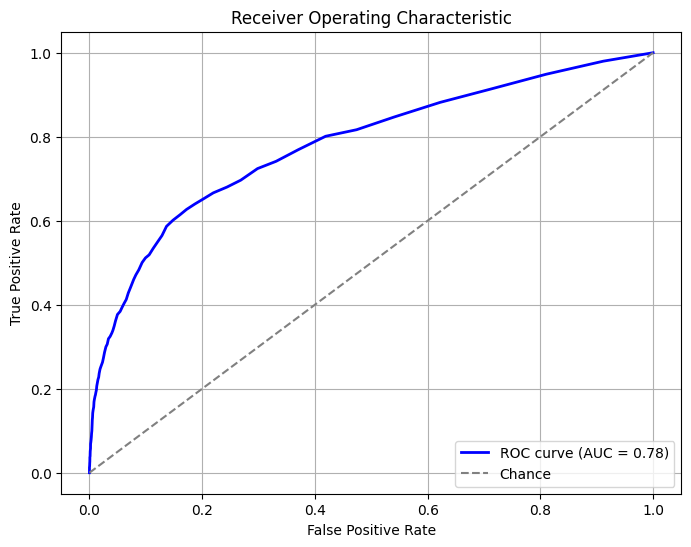

In [71]:
plot_roc_curve(y_prob, y_test)

### Model 4


In [72]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"],
}

In [73]:
rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, cv=5, scoring="f1", n_jobs=-1, verbose=1
)

grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/jmanwillz/Desktop/ACML-Project/ACML-Project/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/jmanwillz/Desktop/ACML-Project/ACML-Project/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/jmanwillz/Desktop/ACML-Project/ACML-Project/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/jmanwillz/Desktop/ACML-Project/ACML-Project/lib/python3.12/site-packages/sklea

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='f1', verbose=1)

In [74]:
print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [75]:
y_pred = best_rf.predict(x_test)
y_prob = best_rf.predict_proba(x_test)[:, 1]

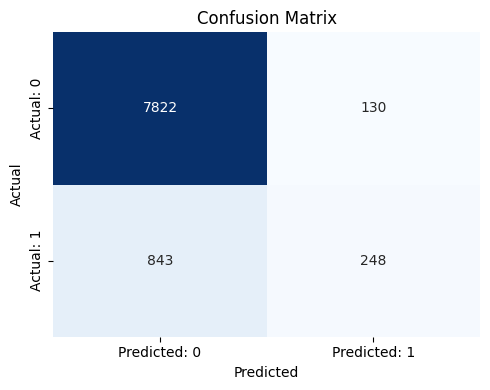

              precision    recall  f1-score   support

       False       0.90      0.98      0.94      7952
        True       0.66      0.23      0.34      1091

    accuracy                           0.89      9043
   macro avg       0.78      0.61      0.64      9043
weighted avg       0.87      0.89      0.87      9043

Accuracy (Calculated): 0.8924029636182683
Accuracy (Library): 0.8924029636182683
Recall: 0.22731439046746105
precision: 0.656084656084656


In [76]:
plot_confusion_matrix(y_pred, y_test)

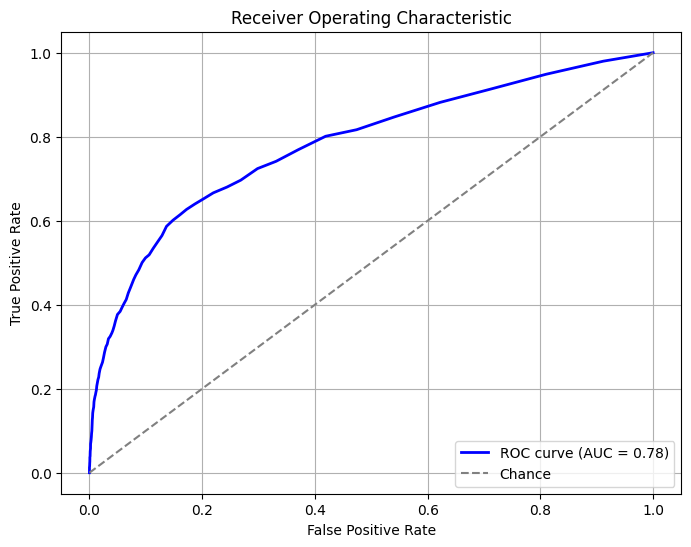

In [77]:
plot_roc_curve(y_prob, y_test)

### Synthetic Minority Oversampling Technique (SMOTE)


In [78]:
smote = SMOTE(random_state=random_sate)
x_resampled, y_resampled = smote.fit_resample(x_train, y_train)

y counts:
y
False    31970
True      4198
Name: count, dtype: int64

Number NA:  0


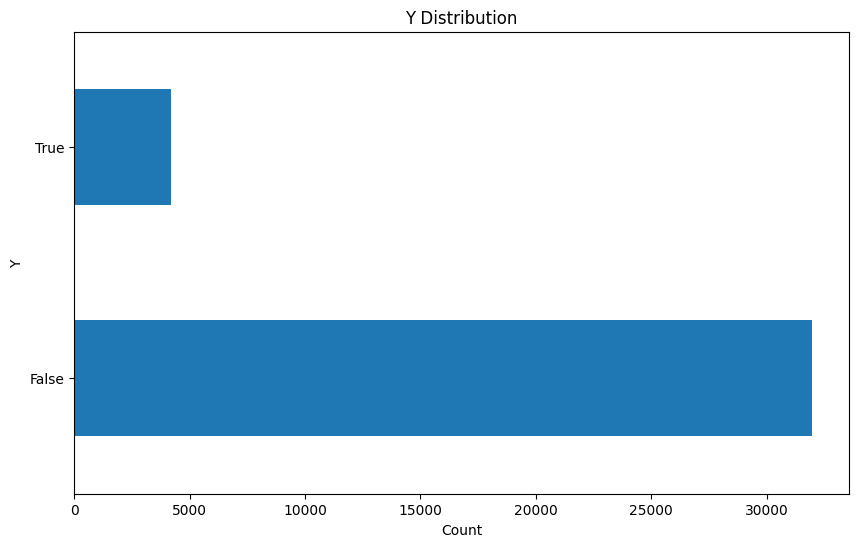

In [79]:
explore_categorical_feature(y_train, "y")

y counts:
y
False    31970
True     31970
Name: count, dtype: int64

Number NA:  0


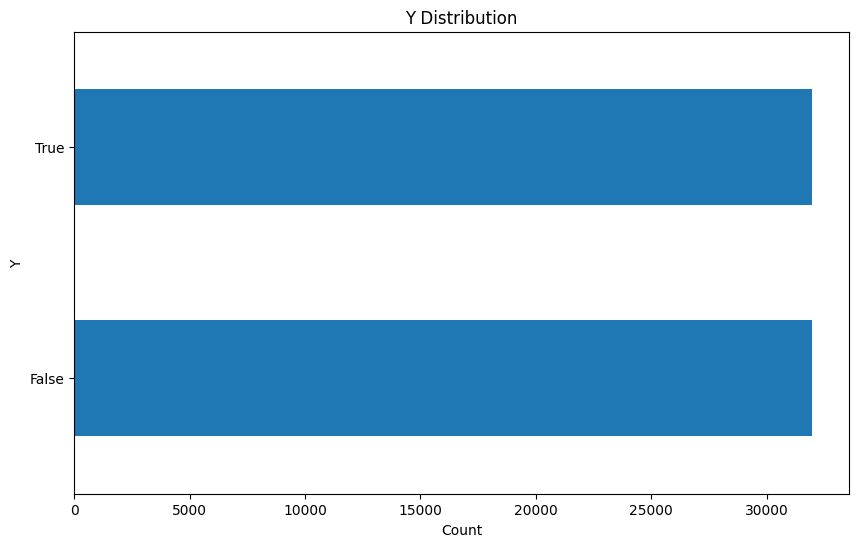

In [80]:
explore_categorical_feature(y_resampled, "y")

### Model 5


In [81]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"],
}

In [82]:
rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf, param_grid=param_grid, cv=5, scoring="roc_auc", n_jobs=-1, verbose=1
)

grid_search.fit(x_resampled, y_resampled)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/jmanwillz/Desktop/ACML-Project/ACML-Project/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/jmanwillz/Desktop/ACML-Project/ACML-Project/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/jmanwillz/Desktop/ACML-Project/ACML-Project/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/jmanwillz/Desktop/ACML-Project/ACML-Project/lib/python3.12/site-packages/sklea

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='roc_auc', verbose=1)

In [83]:
print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

Best Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [84]:
y_pred = best_rf.predict(x_test)
y_prob = best_rf.predict_proba(x_test)[:, 1]

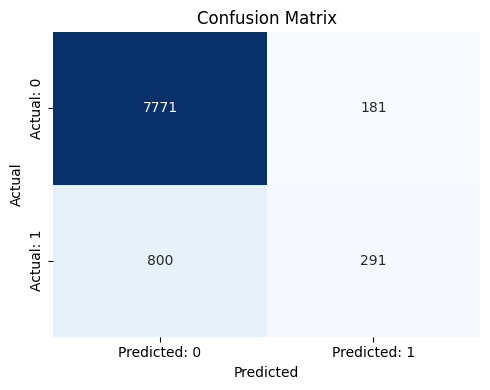

              precision    recall  f1-score   support

       False       0.91      0.98      0.94      7952
        True       0.62      0.27      0.37      1091

    accuracy                           0.89      9043
   macro avg       0.76      0.62      0.66      9043
weighted avg       0.87      0.89      0.87      9043

Accuracy (Calculated): 0.8915183014486343
Accuracy (Library): 0.8915183014486343
Recall: 0.26672777268560954
precision: 0.6165254237288136


In [85]:
plot_confusion_matrix(y_pred, y_test)

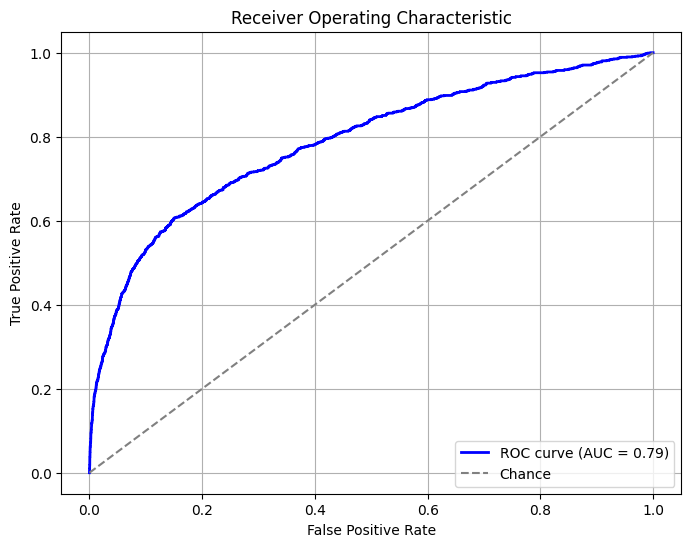

In [86]:
plot_roc_curve(y_prob, y_test)